# NYC Real Estate Uncertainty Estimator

Automated estimator that outputs **Aleatoric** (data noise) and **Epistemic** (model doubt) uncertainty for NYC property prices, with LLM-based feature engineering and SHAP interpretability.

## Phase 1 — Live Data Ingestion

Load NYC Citywide Rolling Calendar Sales CSV, clean SALE PRICE, square footage, derive building age, drop duplicates.

In [ ]:
!pip install seaborn    
!pip install tensorflow
!pip install shap
!pip install matplotlib
!pip install pandas
!pip install numpy


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
  Using cached absl_py-2.4.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.12.19-py2.py3-none-any.whl.metadata (1.0 kB)
  Using cached gast-0.7.0-py3-none-any.whl.metadata (1.5 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-6.33.5-cp39-abi3-macosx_10_9_universal2.whl.metadata (593 bytes)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached setuptools-82.0.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached termcolor-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached tensorboard-2.

In [10]:
!pip install scikit-learn


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [9]:
import os
import json
import random
import numpy as np
import pandas as pd
if os.environ.get("CI"):
    import matplotlib
    matplotlib.use("Agg")
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
warnings.filterwarnings("ignore")

/Users/dmitrii/Desktop/advanced_dl_project/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
df_raw = "NYC_Citywide_Rolling_Calendar_Sales.csv"
df_raw = pd.read_csv(df_raw)
df_raw.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,1,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,376,43,NaN,S1,743 EAST 6 STREET,NaN,...,1.0,1.0,2.0,"2,090",3680.0,1940.0,1,S1,0,01/23/2025
1,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,372,9,NaN,C7,272 EAST 3 STREET,NaN,...,8.0,1.0,9.0,"2,021",7129.0,1900.0,2,C7,0,12/15/2025
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,372,19,NaN,C7,"292 EAST 3 STREET, 4B",NaN,...,9.0,1.0,10.0,"2,401",6920.0,1920.0,2,C7,0,02/07/2025
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,376,41,NaN,C4,"745 EAST 6TH STREET, 1B",NaN,...,28.0,0.0,28.0,"4,542",18254.0,1900.0,2,C4,540000,12/17/2025
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,385,38,NaN,C4,"21-23 AVENUE C, 5B",NaN,...,20.0,2.0,22.0,"3,315",17160.0,1900.0,2,C4,0,11/11/2025


In [12]:
def clean_numeric(ser, remove_commas=True):
    """Coerce to numeric, handling commas and empty strings."""
    if remove_commas:
        ser = ser.astype(str).str.replace(",", "", regex=False)
    return pd.to_numeric(ser, errors="coerce")

# Clean SALE PRICE: strip $/commas, cast to float
df = df_raw.copy()
df["SALE PRICE"] = clean_numeric(df["SALE PRICE"])
df = df[df["SALE PRICE"] > 0].copy()  # Drop $0 sales (transfers)

# Clean GROSS SQUARE FEET and LAND SQUARE FEET
df["GROSS SQUARE FEET"] = clean_numeric(df["GROSS SQUARE FEET"])
df["LAND SQUARE FEET"] = clean_numeric(df["LAND SQUARE FEET"])
df = df[(df["GROSS SQUARE FEET"] > 0) & (df["LAND SQUARE FEET"] > 0)].copy()

# Derive BUILDING AGE
df["YEAR BUILT"] = pd.to_numeric(df["YEAR BUILT"], errors="coerce")
df = df[df["YEAR BUILT"].between(1800, 2025)].copy()
df["BUILDING_AGE"] = 2025 - df["YEAR BUILT"]

# Drop duplicates
df = df.drop_duplicates()

print(f"After cleaning: {len(df):,} rows")
print(df[["SALE PRICE", "GROSS SQUARE FEET", "BUILDING_AGE", "BOROUGH", "NEIGHBORHOOD"]].head())

After cleaning: 23,029 rows
    SALE PRICE  GROSS SQUARE FEET  BUILDING_AGE  BOROUGH   NEIGHBORHOOD
3       540000            18254.0         125.0        1  ALPHABET CITY
7       280000             6875.0         125.0        1  ALPHABET CITY
8      8800000             7166.0         125.0        1  ALPHABET CITY
9      2000000             7810.0         125.0        1  ALPHABET CITY
11     4000000             6990.0         125.0        1  ALPHABET CITY


In [13]:
df.isnull().sum()

BOROUGH                               0
NEIGHBORHOOD                          0
BUILDING CLASS CATEGORY               0
TAX CLASS AT PRESENT                  0
BLOCK                                 0
LOT                                   0
EASE-MENT                         23029
BUILDING CLASS AT PRESENT             0
ADDRESS                               0
APARTMENT NUMBER                  22969
ZIP CODE                              0
RESIDENTIAL UNITS                     0
COMMERCIAL UNITS                      0
TOTAL UNITS                           0
LAND SQUARE FEET                      0
GROSS SQUARE FEET                     0
YEAR BUILT                            0
TAX CLASS AT TIME OF SALE             0
BUILDING CLASS AT TIME OF SALE        0
SALE PRICE                            0
SALE DATE                             0
BUILDING_AGE                          0
dtype: int64

In [14]:
df.drop(columns = ['EASE-MENT','APARTMENT NUMBER'])

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,BUILDING_AGE
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,376,41,C4,"745 EAST 6TH STREET, 1B",10009.0,28.0,0.0,28.0,4542.0,18254.0,1900.0,2,C4,540000,12/17/2025,125.0
7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,400,11,C4,"510 EAST 5TH STREET, 9",10009.0,18.0,0.0,18.0,2404.0,6875.0,1900.0,2,C4,280000,04/29/2025,125.0
8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,400,54,C7,207 EAST 4 STREET,10009.0,8.0,3.0,11.0,2364.0,7166.0,1900.0,2,C7,8800000,11/20/2025,125.0
9,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,36,C4,106 AVENUE B,10009.0,8.0,2.0,10.0,1919.0,7810.0,1900.0,2,C4,2000000,03/13/2025,125.0
11,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,404,42,C4,327 EAST 10 STREET,10009.0,10.0,0.0,10.0,2369.0,6990.0,1900.0,2,C4,4000000,08/07/2025,125.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7267,345,B9,115 SALAMANDER COURT,10309.0,2.0,0.0,2.0,3302.0,1440.0,1996.0,1,B9,765000,02/12/2025,29.0
79326,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7316,4,B9,78 DARNELL LANE,10309.0,2.0,0.0,2.0,3180.0,1300.0,1996.0,1,B9,850000,09/08/2025,29.0
79328,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7317,130,B9,100 ROBIN COURT,10309.0,2.0,0.0,2.0,3700.0,2500.0,1995.0,1,B9,855000,09/16/2025,30.0
79329,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7349,34,B9,37 QUAIL LANE,10309.0,2.0,0.0,2.0,2400.0,2575.0,1998.0,1,B9,885000,10/22/2025,27.0


In [15]:
df.describe()

,BOROUGH,BLOCK,LOT,EASE-MENT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE,BUILDING_AGE
count,23029.000000,23029.000000,23029.000000,0.0,23029.000000,23029.000000,23029.000000,23029.000000,2.302900e+04,2.302900e+04,23029.000000,23029.000000,2.302900e+04,23029.000000
mean,3.496114,5419.106344,64.005341,NaN,11000.334622,3.940987,0.446133,4.387121,7.391625e+03,6.500400e+03,1941.425246,1.271180,2.217135e+06,83.574754
std,1.027140,3737.190809,148.505404,NaN,474.538948,22.921838,7.259724,24.084410,1.429428e+05,4.405479e+04,30.991045,0.736628,1.588107e+07,30.991045
min,1.000000,8.000000,1.000000,NaN,10001.000000,0.000000,0.000000,0.000000,2.970000e+02,2.000000e+02,1800.000000,1.000000,1.000000e+00,0.000000
25%,3.000000,2471.000000,19.000000,NaN,10463.000000,1.000000,0.000000,1.000000,2.000000e+03,1.412000e+03,1920.000000,1.000000,6.700000e+05,65.000000
50%,4.000000,4886.000000,38.000000,NaN,11221.000000,2.000000,0.000000,2.000000,2.500000e+03,2.000000e+03,1931.000000,1.000000,9.270000e+05,94.000000
75%,4.000000,7631.000000,64.000000,NaN,11370.000000,2.000000,0.000000,2.000000,4.000000e+03,2.910000e+03,1960.000000,1.000000,1.400000e+06,105.000000
max,5.000000,16319.000000,8005.000000,NaN,11694.000000,602.000000,472.000000,606.000000,7.446955e+06,1.545708e+06,2025.000000,4.000000,1.080000e+09,225.000000


In [16]:
df.info()

<class 'pandas.DataFrame'>
Index: 23029 entries, 3 to 79334
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   BOROUGH                         23029 non-null  int64  
 1   NEIGHBORHOOD                    23029 non-null  str    
 2   BUILDING CLASS CATEGORY         23029 non-null  str    
 3   TAX CLASS AT PRESENT            23029 non-null  str    
 4   BLOCK                           23029 non-null  int64  
 5   LOT                             23029 non-null  int64  
 6   EASE-MENT                       0 non-null      float64
 7   BUILDING CLASS AT PRESENT       23029 non-null  str    
 8   ADDRESS                         23029 non-null  str    
 9   APARTMENT NUMBER                60 non-null     str    
 10  ZIP CODE                        23029 non-null  float64
 11  RESIDENTIAL UNITS               23029 non-null  float64
 12  COMMERCIAL UNITS                23029 non-null  

In [17]:
df.nunique()

BOROUGH                               5
NEIGHBORHOOD                        245
BUILDING CLASS CATEGORY              23
TAX CLASS AT PRESENT                  6
BLOCK                              9242
LOT                                 629
EASE-MENT                             0
BUILDING CLASS AT PRESENT           111
ADDRESS                           22641
APARTMENT NUMBER                     22
ZIP CODE                            176
RESIDENTIAL UNITS                   122
COMMERCIAL UNITS                     51
TOTAL UNITS                         133
LAND SQUARE FEET                   4140
GROSS SQUARE FEET                  4452
YEAR BUILT                          156
TAX CLASS AT TIME OF SALE             3
BUILDING CLASS AT TIME OF SALE      109
SALE PRICE                         3999
SALE DATE                           320
BUILDING_AGE                        156
dtype: int64

In [18]:
df = df.drop(columns=['EASE-MENT', 'APARTMENT NUMBER', 'BLOCK', 'LOT', 'ADDRESS', 'SALE DATE'])

In [19]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BUILDING CLASS AT PRESENT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,BUILDING_AGE
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,C4,10009.0,28.0,0.0,28.0,4542.0,18254.0,1900.0,2,C4,540000,125.0
7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,C4,10009.0,18.0,0.0,18.0,2404.0,6875.0,1900.0,2,C4,280000,125.0
8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,C7,10009.0,8.0,3.0,11.0,2364.0,7166.0,1900.0,2,C7,8800000,125.0
9,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,C4,10009.0,8.0,2.0,10.0,1919.0,7810.0,1900.0,2,C4,2000000,125.0
11,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,C4,10009.0,10.0,0.0,10.0,2369.0,6990.0,1900.0,2,C4,4000000,125.0


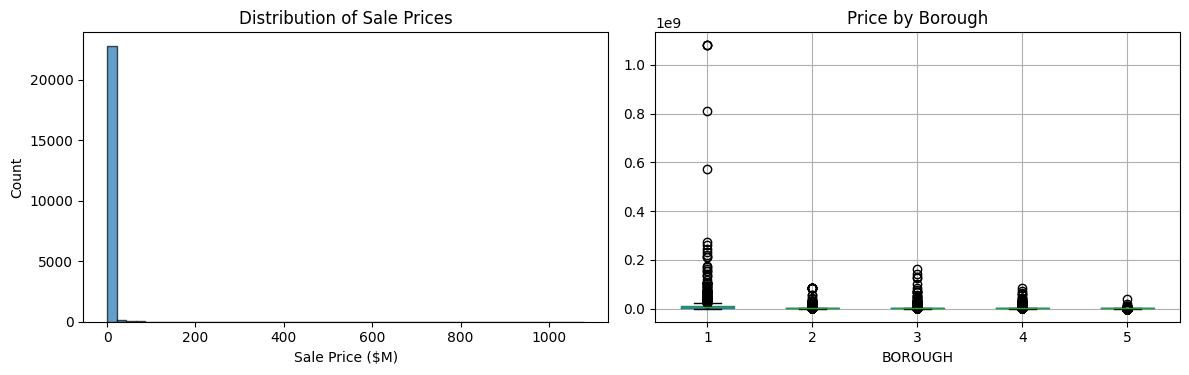

In [20]:
#Price distribution (histogram + boxplot)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(df["SALE PRICE"] / 1e6, bins=50, edgecolor="black", alpha=0.7)
axes[0].set_xlabel("Sale Price ($M)")
axes[0].set_ylabel("Count")
axes[0].set_title("Distribution of Sale Prices")
df.boxplot(column="SALE PRICE", by="BOROUGH", ax=axes[1])
axes[1].set_title("Price by Borough")
plt.suptitle("")
plt.tight_layout()
plt.show()

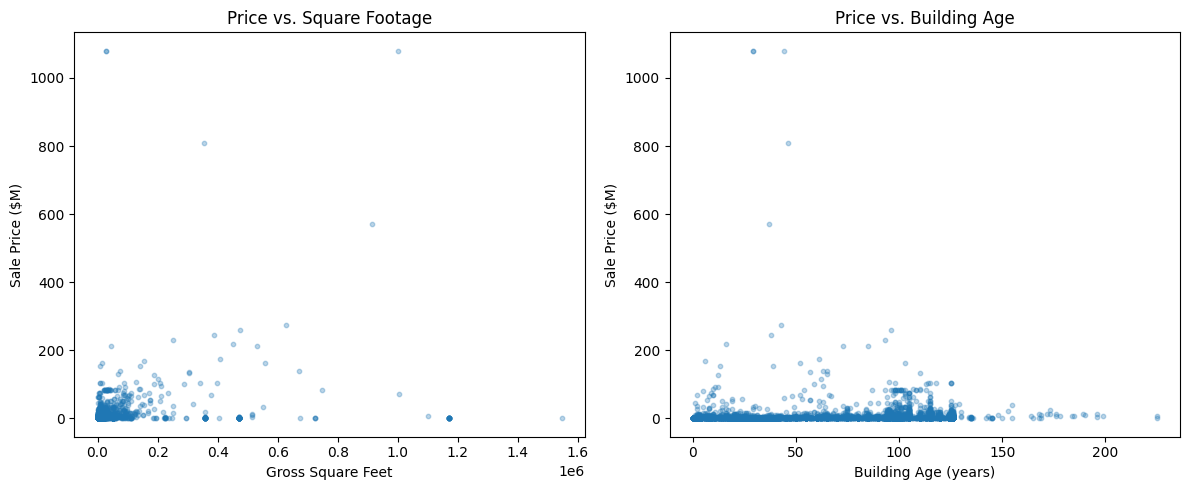

In [21]:
# Price vs. key features (scatter)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(df["GROSS SQUARE FEET"], df["SALE PRICE"] / 1e6, alpha=0.3, s=10)
axes[0].set_xlabel("Gross Square Feet")
axes[0].set_ylabel("Sale Price ($M)")
axes[0].set_title("Price vs. Square Footage")
axes[1].scatter(df["BUILDING_AGE"], df["SALE PRICE"] / 1e6, alpha=0.3, s=10)
axes[1].set_xlabel("Building Age (years)")
axes[1].set_ylabel("Sale Price ($M)")
axes[1].set_title("Price vs. Building Age")
plt.tight_layout()
plt.show()

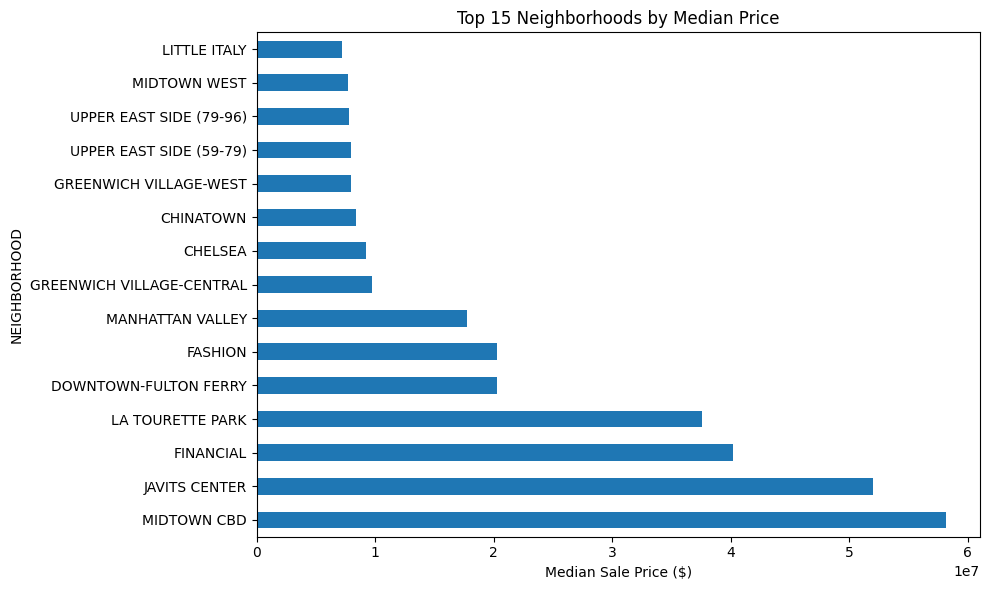

In [22]:
# Top neighborhoods by median price (bar chart)
top_n = df.groupby("NEIGHBORHOOD")["SALE PRICE"].median().nlargest(15)
top_n.plot(kind="barh", figsize=(10, 6))
plt.xlabel("Median Sale Price ($)")
plt.title("Top 15 Neighborhoods by Median Price")
plt.tight_layout()
plt.show()

In [58]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BUILDING CLASS AT PRESENT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,BUILDING_AGE,sub_region,affluence_score
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,C4,10009.0,28.0,0.0,28.0,4542.0,18254.0,1900.0,2,C4,540000,125.0,Manhattan_ALPHABET C,8
7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,C4,10009.0,18.0,0.0,18.0,2404.0,6875.0,1900.0,2,C4,280000,125.0,Manhattan_ALPHABET C,8
8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,C7,10009.0,8.0,3.0,11.0,2364.0,7166.0,1900.0,2,C7,8800000,125.0,Manhattan_ALPHABET C,8
9,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,C4,10009.0,8.0,2.0,10.0,1919.0,7810.0,1900.0,2,C4,2000000,125.0,Manhattan_ALPHABET C,8
11,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,C4,10009.0,10.0,0.0,10.0,2369.0,6990.0,1900.0,2,C4,4000000,125.0,Manhattan_ALPHABET C,8


In [71]:
# Aggressive price filter: residential sales between $100k and $5M only
# (avoids hidden outliers and $100M+ skew; first model focuses on typical residential range)
PRICE_MIN, PRICE_MAX = 100_000, 5_000_000
df = df[(df["SALE PRICE"] >= PRICE_MIN) & (df["SALE PRICE"] <= PRICE_MAX)].copy()
# Optional: restrict to buildings with residential units
df = df[df["RESIDENTIAL UNITS"] > 0].copy()
print(f"After price filter ($100k–$5M, residential): {len(df):,} rows")

## Phase 3 — Two-Headed Model (Aleatoric + Epistemic)

Architecture: shared Dense layers with Dropout (MC Dropout), two heads for mean (μ) and log-variance (σ²). Loss: Gaussian NLL. Target: log(SALE PRICE) for heteroscedastic NYC prices.

In [72]:
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.config.experimental.enable_op_determinism()

set_seeds(42)

# One-hot encode BOROUGH and sub_region (no ordinal — Borough 5 is not "greater" than 1)
borough_dummies = pd.get_dummies(df["BOROUGH"].astype(str), prefix="borough")
sub_region_dummies = pd.get_dummies(df["sub_region"].astype(str), prefix="sub_region")
X_df = pd.concat([
    df[["GROSS SQUARE FEET", "BUILDING_AGE", "affluence_score"]],
    borough_dummies,
    sub_region_dummies
], axis=1)
feature_names = X_df.columns.tolist()
X = X_df.values

y_raw = df["SALE PRICE"].values
y = np.log(y_raw)  # Log-transform; keep in log space (no target scaling)

# Train/test split
X_train, X_test, y_train, y_test, y_train_raw, y_test_raw = train_test_split(
    X, y, y_raw, test_size=0.2, random_state=42
)

# Scale features only; target stays in log space so NLL and predictions are consistent
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

print(f"Features: {X_train.shape[1]}, Train: {len(X_train)}, Test: {len(X_test)}")
print(f"log(price) range: [{y_train.min():.2f}, {y_train.max():.2f}]")


Features: 3, Train: 16350, Test: 4088
y_range (log space): 14.7278


In [73]:
# Baseline: Linear Regression
baseline = LinearRegression()
baseline.fit(X_train, y_train)
y_baseline = baseline.predict(X_test)
y_baseline_raw = np.exp(y_baseline)
print("Baseline (Linear Regression) on log(price):")
print(f"  R2: {r2_score(y_test, baseline.predict(X_test)):.4f}")
print(f"  MAE (dollars): ${mean_absolute_error(y_test_raw, y_baseline_raw):,.0f}")


Baseline (Linear Regression) on log(price):
  R2: -0.0006
  MAE (dollars): $548,985


In [74]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Concatenate
from tensorflow.keras.callbacks import EarlyStopping

def aleatoric_loss(y_true, y_pred):
    # NLL in log space: y_true and mu are log(price); no scaling so R2/MAE are interpretable.
    mu = y_pred[:, 0:1]
    sigma_sq = y_pred[:, 1:2]
    epsilon = 1e-6
    return tf.reduce_mean(
        0.5 * tf.math.log(sigma_sq + epsilon) +
        0.5 * tf.math.divide(tf.square(y_true - mu), sigma_sq + epsilon)
    )

def make_combined_model(n_features):
    inputs = Input(shape=(n_features,))
    x = Dense(128, activation="relu")(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x, training=True)  # MC Dropout always on at inference

    x = Dense(64, activation="relu")(x)
    x = BatchNormalization()(x)

    mu = Dense(1, name="mu")(x)
    sigma_sq = Dense(1, activation="softplus", name="sigma_sq")(x)
    return tf.keras.Model(inputs=inputs, outputs=Concatenate()([mu, sigma_sq]))

model = make_combined_model(X_train.shape[1])
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=aleatoric_loss)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │        512 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mu (Dense)          │ (None, 1)         │         65 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sigma_sq (Dense)    │ (None, 1)         │         65 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 2)         │          0 │ mu[0][0],         │
│ (Concatenate)       │                   │            │ sigma_sq[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,666 (37.76 KB)

 Trainable params: 9,282 (36.26 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/300


2026-02-24 21:46:11.781106: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: -0.1261 - val_loss: -0.5109
Epoch 2/300
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: -0.9163 - val_loss: -1.0708
Epoch 3/300
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - loss: -1.1255 - val_loss: -1.1419
Epoch 4/300
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - loss: -1.1616 - val_loss: -1.1481
Epoch 5/300
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: -1.1744 - val_loss: -1.1518
Epoch 6/300
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: -1.1808 - val_loss: -1.1416
Epoch 7/300
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - loss: -1.1842 - val_loss: -1.1548
Epoch 8/300
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - loss: -1.1872 - val_loss: -1.1540
Epoch 9/300
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - loss: -1.1890 - val_loss: -1.1611
Epoch 10/300
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -1.1887 - val_loss: -1.1592
Epoch 11/300
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -1.1898 - val_loss: -1.1595
Epoch 12/300
40

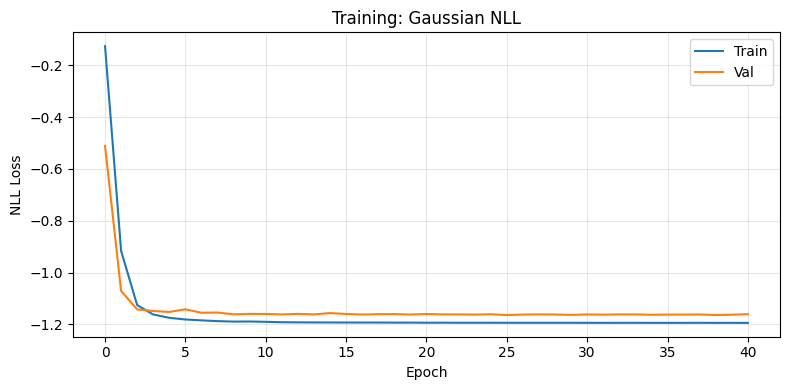

In [75]:
history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=15, restore_best_weights=True)],
    verbose=1
)

# Loss curves
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(history.history["loss"], label="Train")
ax.plot(history.history["val_loss"], label="Val")
ax.set_xlabel("Epoch")
ax.set_ylabel("NLL Loss")
ax.set_title("Training: Gaussian NLL")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [76]:
# Point estimate metrics (mu head, converted to dollars)
y_pred_log = model.predict(X_test)[:, 0]  # mu already in log space
y_pred_dollars = np.exp(y_pred_log)

print("Two-headed model (point estimate):")
print(f"  R2 (log): {r2_score(y_test, y_pred_log):.4f}")
print(f"  MAE (dollars): ${mean_absolute_error(y_test_raw, y_pred_dollars):,.0f}")
print(f"  RMSE (dollars): ${np.sqrt(mean_squared_error(y_test_raw, y_pred_dollars)):,.0f}")


 19/128 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

2026-02-24 21:46:31.736978: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Two-headed model (point estimate):
  R2 (log): -0.0149
  MAE (dollars): $617,295
  RMSE (dollars): $749,194


## Phase 4 — Uncertainty & SHAP Analysis

Compute epistemic (MC Dropout) and aleatoric (learned variance) uncertainty, interval coverage, and outlier inspection.

In [77]:
T = 50
preds = np.stack([model(X_test, training=True).numpy() for _ in range(T)])
all_mu_log = preds[:, :, 0]  # mu already in log space
all_sigma_sq_log = preds[:, :, 1]  # variance in log space

# Epistemic: variance of predicted means across MC passes
epistemic_var_log = all_mu_log.var(axis=0)
epistemic_std_log = np.sqrt(epistemic_var_log)
# Convert to dollars (delta method: std_dollars ≈ price * std_log)
mu_mean_log = all_mu_log.mean(axis=0)
mu_mean_dollars = np.exp(mu_mean_log)
epistemic_std_dollars = mu_mean_dollars * epistemic_std_log

# Aleatoric: mean of predicted variances
aleatoric_var_log = all_sigma_sq_log.mean(axis=0)
aleatoric_std_log = np.sqrt(aleatoric_var_log)
aleatoric_std_dollars = mu_mean_dollars * aleatoric_std_log

# Total uncertainty
total_std_dollars = np.sqrt(epistemic_var_log * (mu_mean_dollars**2) + aleatoric_var_log * (mu_mean_dollars**2))
# Simpler: total_std ≈ sqrt(epistemic_std^2 + aleatoric_std^2) in dollar space
total_std_dollars = np.sqrt(epistemic_std_dollars**2 + aleatoric_std_dollars**2)

print("Uncertainty (dollars) - sample stats:")
print(f"  Epistemic std: mean=${epistemic_std_dollars.mean():,.0f}, max=${epistemic_std_dollars.max():,.0f}")
print(f"  Aleatoric std:  mean=${aleatoric_std_dollars.mean():,.0f}, max=${aleatoric_std_dollars.max():,.0f}")


Uncertainty (dollars) - sample stats:
  Epistemic std: mean=$11,753, max=$75,606
  Aleatoric std:  mean=$909,639, max=$1,054,292


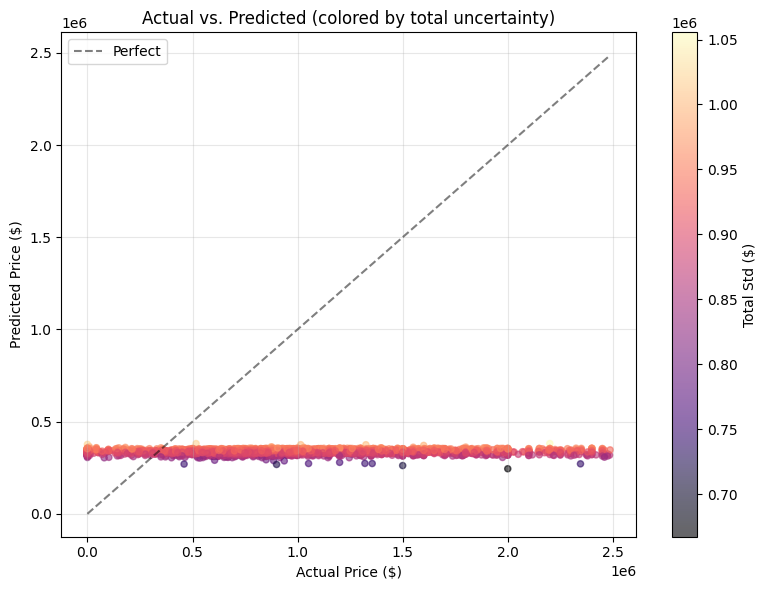

In [78]:
# Actual vs. Predicted scatter (colored by total uncertainty)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sc = ax.scatter(y_test_raw, mu_mean_dollars, c=total_std_dollars, cmap="magma", alpha=0.6, s=20)
ax.plot([0, y_test_raw.max()], [0, y_test_raw.max()], "k--", alpha=0.5, label="Perfect")
ax.set_xlabel("Actual Price ($)")
ax.set_ylabel("Predicted Price ($)")
ax.set_title("Actual vs. Predicted (colored by total uncertainty)")
plt.colorbar(sc, ax=ax, label="Total Std ($)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

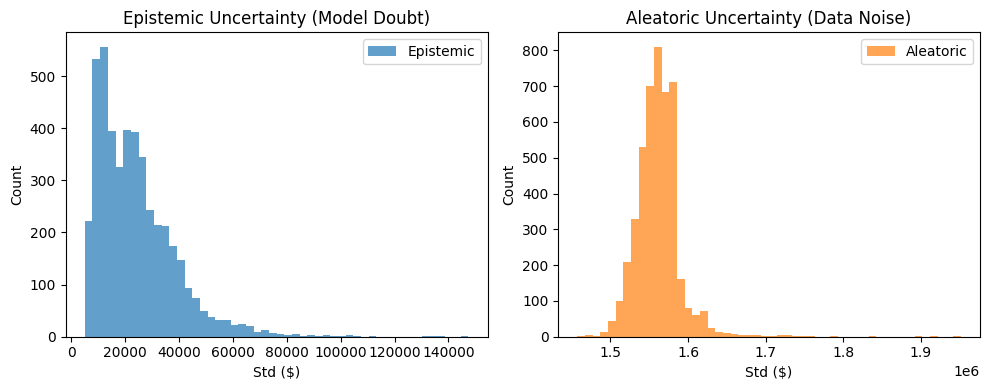

In [66]:
# Uncertainty histograms: epistemic vs. aleatoric
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(epistemic_std_dollars, bins=50, alpha=0.7, label="Epistemic", color="C0")
axes[0].set_xlabel("Std ($)")
axes[0].set_ylabel("Count")
axes[0].set_title("Epistemic Uncertainty (Model Doubt)")
axes[0].legend()
axes[1].hist(aleatoric_std_dollars, bins=50, alpha=0.7, label="Aleatoric", color="C1")
axes[1].set_xlabel("Std ($)")
axes[1].set_ylabel("Count")
axes[1].set_title("Aleatoric Uncertainty (Data Noise)")
axes[1].legend()
plt.tight_layout()
plt.show()

95% Gaussian interval coverage: 92.99% (target: 95%)


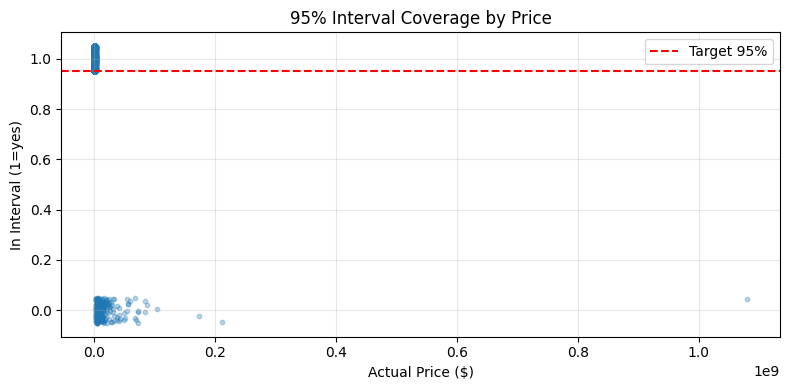

In [67]:
# 95% interval coverage (Gaussian)
z = 1.96
lower = mu_mean_dollars - z * total_std_dollars
upper = mu_mean_dollars + z * total_std_dollars
hits = (y_test_raw >= lower) & (y_test_raw <= upper)
coverage = hits.mean()
print(f"95% Gaussian interval coverage: {coverage:.2%} (target: 95%)")

# Plot hit rate vs. actual price
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.scatter(y_test_raw, hits.astype(float) + np.random.uniform(-0.05, 0.05, len(hits)), alpha=0.3, s=10)
ax.axhline(0.95, color="red", linestyle="--", label="Target 95%")
ax.set_xlabel("Actual Price ($)")
ax.set_ylabel("In Interval (1=yes)")
ax.set_title("95% Interval Coverage by Price")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Unpredictable luxury cluster: 121 properties (high price + high aleatoric uncertainty)
  Price P90: $2,562,500, Aleatoric std P90: $1,585,958


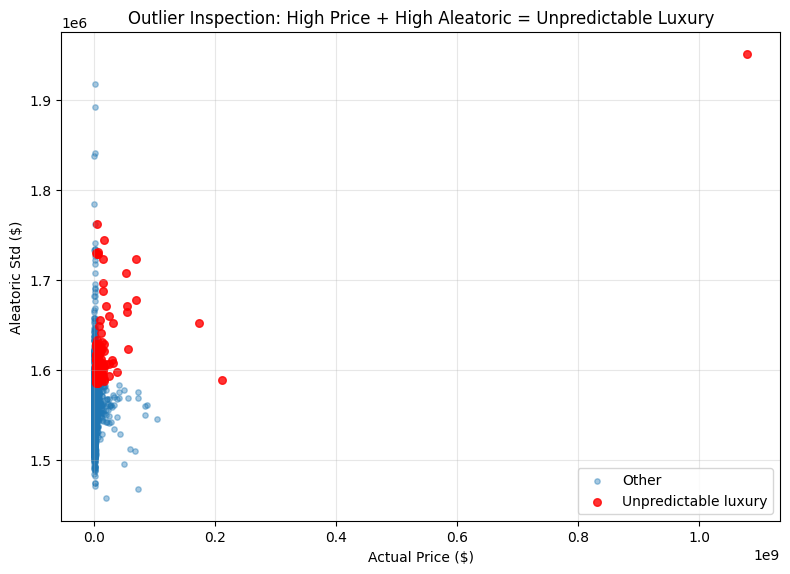

In [68]:
# Outlier inspection: high price AND high aleatoric uncertainty ("unpredictable luxury")
price_p90 = np.percentile(y_test_raw, 90)
aleatoric_p90 = np.percentile(aleatoric_std_dollars, 90)
unpredictable_luxury = (y_test_raw >= price_p90) & (aleatoric_std_dollars >= aleatoric_p90)
n_outliers = unpredictable_luxury.sum()
print(f"Unpredictable luxury cluster: {n_outliers} properties (high price + high aleatoric uncertainty)")
print(f"  Price P90: ${price_p90:,.0f}, Aleatoric std P90: ${aleatoric_p90:,.0f}")

# Scatter: price vs aleatoric, highlight unpredictable luxury
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(y_test_raw[~unpredictable_luxury], aleatoric_std_dollars[~unpredictable_luxury], alpha=0.4, s=15, label="Other")
ax.scatter(y_test_raw[unpredictable_luxury], aleatoric_std_dollars[unpredictable_luxury], alpha=0.8, s=30, c="red", label="Unpredictable luxury")
ax.set_xlabel("Actual Price ($)")
ax.set_ylabel("Aleatoric Std ($)")
ax.set_title("Outlier Inspection: High Price + High Aleatoric = Unpredictable Luxury")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### SHAP Interpretation

Three predictor wrappers for SHAP: price (mean), epistemic std, aleatoric std. Use KernelExplainer for each.

In [ ]:
def predict_mean_final(x_np):
    preds = model(x_np, training=False).numpy()
    mu_log = preds[:, 0]  # already in log space
    return np.exp(mu_log)

def predict_epistemic_final(x_np):
    preds = np.stack([model(x_np, training=True).numpy() for _ in range(50)])
    all_mu_log = preds[:, :, 0]  # already in log space
    all_mu_dollars = np.exp(all_mu_log)
    return all_mu_dollars.std(axis=0)

def predict_aleatoric_final(x_np):
    preds = model(x_np, training=False).numpy()
    mu_log = preds[:, 0]
    sigma_sq_log = preds[:, 1].flatten()
    aleatoric_std_log = np.sqrt(sigma_sq_log)
    return np.exp(mu_log) * aleatoric_std_log

# Subset for SHAP (KernelExplainer is slow)
X_subset = X_test[:40]
# feature_names from feature prep cell (one-hot + numeric)
background = shap.sample(X_train, 100)


In [ ]:
# Beeswarm summary plots for all three heads
surgical_predictors = {
    "Price (Mean)": predict_mean_final,
    "Model Doubt (Epistemic)": predict_epistemic_final,
    "Data Noise (Aleatoric)": predict_aleatoric_final,
}
for title, func in surgical_predictors.items():
    print(f"SHAP beeswarm: {title}...")
    explainer = shap.KernelExplainer(func, background)
    sv = explainer.shap_values(X_subset, nsamples=500)
    if isinstance(sv, list):
        sv = sv[0]
    plt.figure(figsize=(10, 6))
    shap.summary_plot(sv, X_subset, feature_names=feature_names, show=False)
    plt.title(f"SHAP: {title}", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()

In [ ]:
# Dependence plots for affluence_score and GROSS SQUARE FEET
for title, func in surgical_predictors.items():
    explainer = shap.KernelExplainer(func, background)
    sv = explainer.shap_values(X_subset, nsamples=500)
    if isinstance(sv, list):
        sv = sv[0]
    exp = shap.Explanation(values=sv, data=X_subset, feature_names=feature_names, base_values=explainer.expected_value)
    for feat in ["affluence_score", "GROSS SQUARE FEET"]:
        if feat in feature_names:
            idx = feature_names.index(feat)
            plt.figure(figsize=(8, 5))
            shap.plots.scatter(exp[:, feat], color=exp, show=False)
            plt.title(f"{title} vs {feat}")
            plt.tight_layout()
            plt.show()

In [ ]:
# Waterfall plots for the most uncertain house
max_unc_idx = np.argmax(total_std_dollars)
for title, func in surgical_predictors.items():
    explainer = shap.KernelExplainer(func, background)
    sv = explainer.shap_values(X_test[max_unc_idx : max_unc_idx + 1], nsamples=500)
    if isinstance(sv, list):
        sv = sv[0]
    exp_single = shap.Explanation(
        values=sv[0],
        base_values=explainer.expected_value,
        data=X_test[max_unc_idx],
        feature_names=feature_names,
    )
    plt.figure(figsize=(10, 6))
    shap.plots.waterfall(exp_single, show=False)
    plt.title(f"Waterfall: {title} for Most Uncertain Property", fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
# Four-quadrant SHAP magnitude x uncertainty magnitude
targets = {"mean": predict_mean_final, "epistemic": predict_epistemic_final, "aleatoric": predict_aleatoric_final}
sv_results = {}
for name, func in targets.items():
    explainer = shap.KernelExplainer(func, background)
    sv = explainer.shap_values(X_subset, nsamples=500)
    if isinstance(sv, list):
        sv = sv[0]
    sv_results[name] = sv

shap_mag = np.abs(sv_results["mean"]).sum(axis=1)
unc_mag = np.abs(sv_results["epistemic"]).sum(axis=1) + np.abs(sv_results["aleatoric"]).sum(axis=1)
med_shap, med_unc = np.median(shap_mag), np.median(unc_mag)
quadrant = np.where(shap_mag >= med_shap, 1, 0) + np.where(unc_mag >= med_unc, 2, 0)
labels = {0: "Boring but Reliable", 1: "Confident Signal", 2: "Uncertain & Uninformative", 3: "Strong Claim, Low Confidence"}

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for q, lbl in labels.items():
    mask = quadrant == q
    ax.scatter(shap_mag[mask], unc_mag[mask], alpha=0.6, label=lbl, s=40)
ax.axvline(med_shap, color="gray", linestyle="--", alpha=0.5)
ax.axhline(med_unc, color="gray", linestyle="--", alpha=0.5)
ax.set_xlabel("|SHAP| (Price Impact)")
ax.set_ylabel("|SHAP| (Uncertainty Impact)")
ax.set_title("Four-Quadrant: SHAP Magnitude vs Uncertainty Magnitude")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Save uncertainty report for GCP/GitHub Actions (when GCS_BUCKET or CI is set)
if os.environ.get("GCS_BUCKET") or os.environ.get("CI"):
    try:
        _base = os.path.dirname(os.path.abspath(__file__))
        report_dir = os.path.join(os.path.dirname(_base), "reports")
    except NameError:
        report_dir = os.path.join(os.getcwd(), "reports")
    os.makedirs(report_dir, exist_ok=True)
    report_df = pd.DataFrame({
        "actual_price": y_test_raw,
        "predicted_price": mu_mean_dollars,
        "epistemic_std": epistemic_std_dollars,
        "aleatoric_std": aleatoric_std_dollars,
        "total_std": total_std_dollars,
        "in_95_interval": hits,
    })
    report_path = os.path.join(report_dir, "uncertainty_report.csv")
    report_df.to_csv(report_path, index=False)
    print(f"Saved uncertainty report to {report_path}")